# Demo: analysing soil moisture data from the Climate Data Store in xcube

First, we import some necessary libraries and configure some matplotlib display preferences.

In [1]:
# xcube_cds imports
from xcube_cds.store import CDSDataStore

# xcube imports
import xcube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry
from xcube.core.dsio import open_cube

# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import time
import zarr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pathlib

# Plot settings
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

Create a CDS data store object. The optional `normalize_names` parameter specifies that variable names in returned data cubes will be converted to legal Python identifiers, if required.

In [2]:
cds_store = CDSDataStore(normalize_names=True)

From the data store we request monthly averages of global volumetric soil moisture data from January 2015 to January 2016.

In [3]:
generated_cube = cds_store.open_data(
    'satellite-soil-moisture:volumetric:monthly',
    variable_names=['volumetric_surface_soil_moisture'],
    bbox=[-180, -90, 180, 90],
    spatial_res=0.25,
    time_period='1M',
    time_range=['2015-01-01', '2016-01-31']
)
cube = generated_cube

2020-10-07 16:28:56,053 INFO Welcome to the CDS
2020-10-07 16:28:56,056 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-soil-moisture
2020-10-07 16:28:56,606 INFO Request is completed
2020-10-07 16:28:56,607 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data4/dataset-satellite-soil-moisture-abaf004d-f885-4bdd-a532-d982164c6f8e.tar.gz to /tmp/tmpwvc1u407/tmprb0og0w_/data (18.4M)
2020-10-07 16:29:01,699 INFO Download rate 3.6M/s   


Plot the bounding box on a map to check that the cube covers the expected area.

In [4]:
bbox = [min(cube.lon), min(cube.lat), max(cube.lon), max(cube.lat)]
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

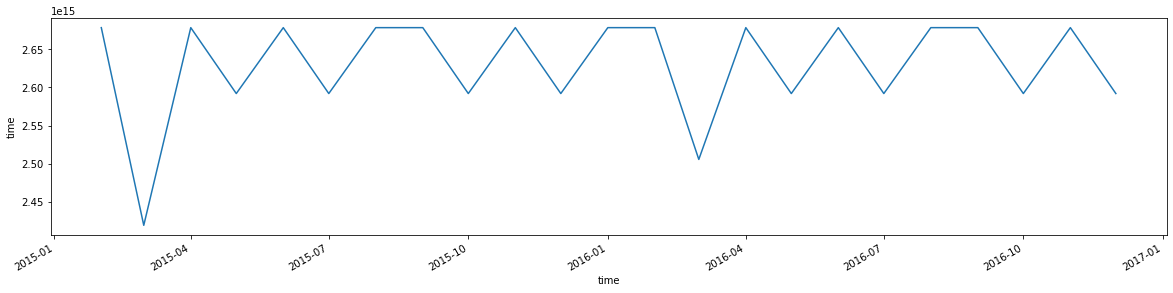

In [5]:
cube.time.diff(dim='time').plot.line(figsize=(20, 4))

As a quick initial test, we plot a simple plate carrée projection (with longitude and latitude mapped directly to the x and y co-ordinates respectively) for the first time-point available.

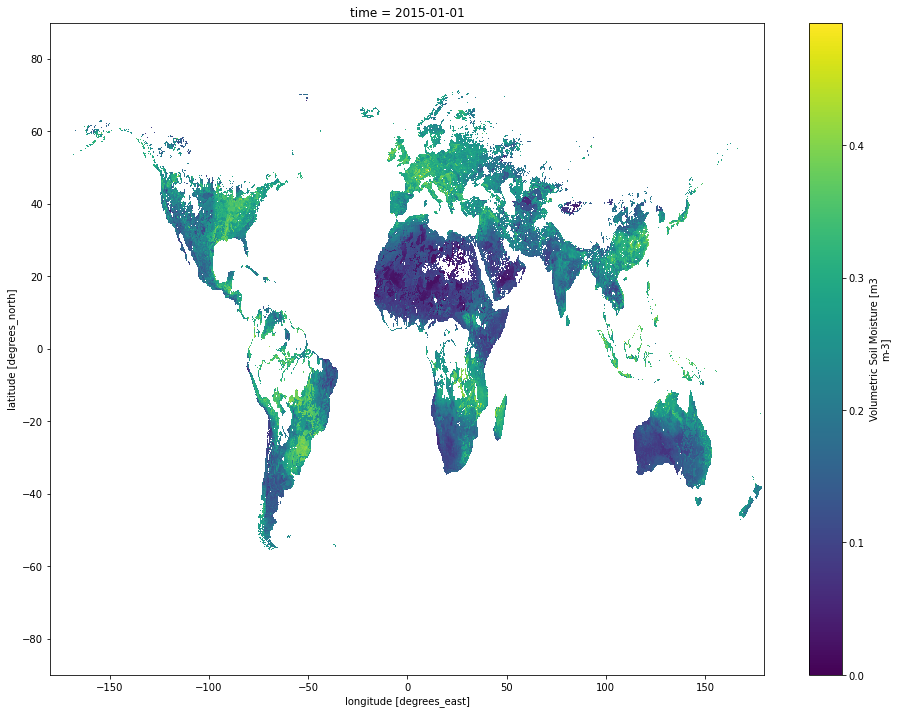

In [6]:
sm_2015_jan = cube.sm.sel(time='2015-01-01 00:00:00', method='nearest')
sm_2015_jan.plot.imshow()

Now we define a slightly more sophisticated plotting function which we'll use for the plots in the remainder of this demonstration. This function creates an orthographic projection centred over Europe, adds a latitude/longitude grid, and overlays a plot of the coastlines to make the data easier to interpret.

In [7]:
def plot_map(data_array, colour_scale=(None, None), cmap=None):
    mid_lat = 48
    mid_lon = 14
    proj = ccrs.Orthographic(central_longitude=mid_lon, central_latitude=mid_lat)
    ax = plt.axes(projection=proj)
    im = data_array.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=colour_scale[0], vmax=colour_scale[1], cmap=cmap)
    ax.coastlines(resolution='50m')
    ax.set_extent((-2e6, 2e6, -1.4e6, 1.6e6), crs=proj)
    draw_labels = False  # only supported from cartopy 0.18.0 onwards
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=draw_labels, color='#000000', alpha=0.5, linestyle='--')
    gl.xlocator = mpl.ticker.FixedLocator([-10, 0, 10, 20, 30, 40])
    gl.ylocator = mpl.ticker.FixedLocator([35, 40, 45, 50, 55, 60])
    plt.colorbar(im, fraction=0.041, pad=0.04)

First we plot the soil moisture for January 2015. We use an inverted version of the matplotlib ‘viridis’ colour map ranging from yellow (least moisture) to dark blue (most moisture). 

/home/pont/loc/env/xcube-cds-mamba/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


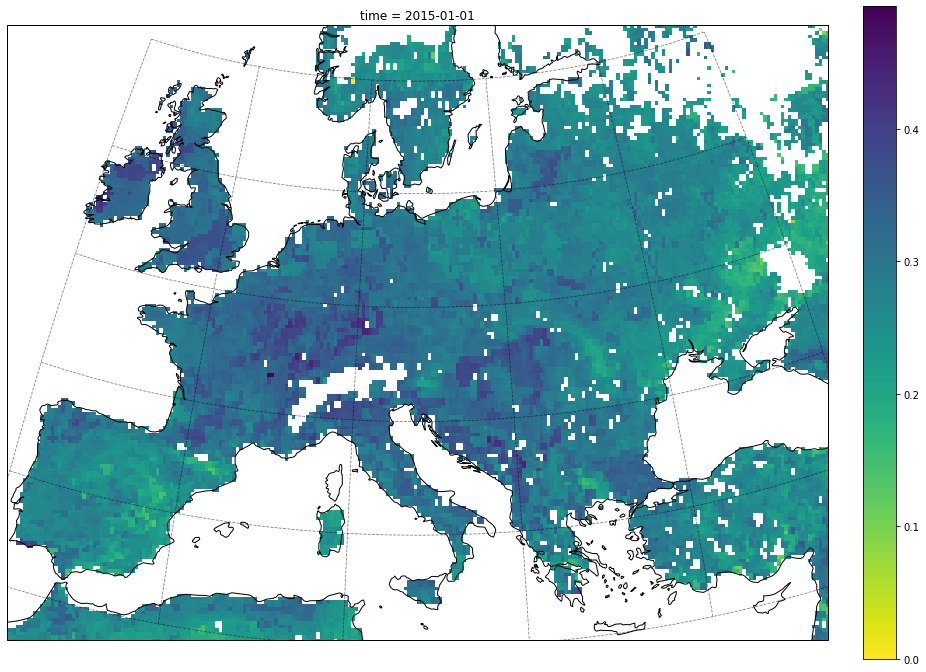

In [8]:
plot_map(sm_2015_jan, cmap='viridis_r')

For comparison, we plot the data for July 2015. Note the overall lower moisture levels (particularly in southern regions) and the improved coverage at higher altitudes and latitudes (probably due to less snow and ice cover).

/home/pont/loc/env/xcube-cds-mamba/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


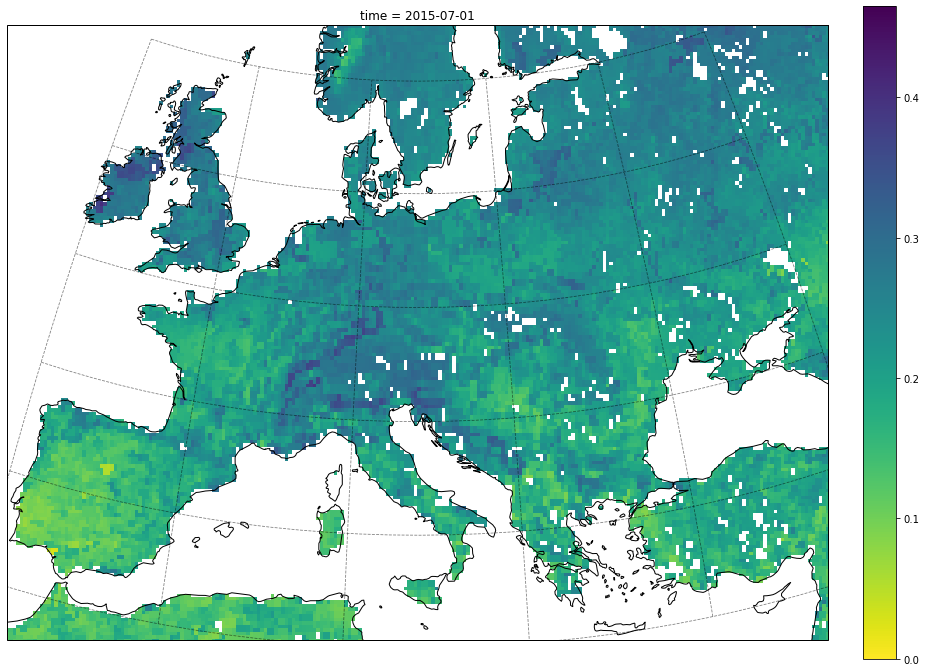

In [9]:
sm_2015_jul = cube.sm.sel(time='2015-07-01 00:00:00', method='nearest')
plot_map(sm_2015_jul, cmap='viridis_r')

By subtracting the January data from the July data, we can see more clearly where the soil moisture decreases the most in the summer.

/home/pont/loc/env/xcube-cds-mamba/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


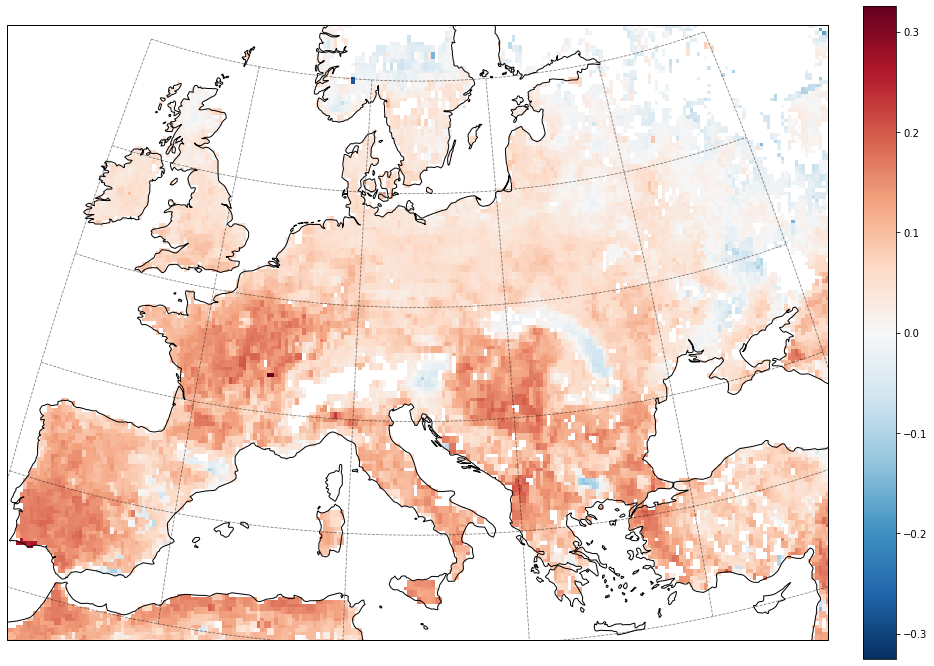

In [10]:
plot_map(sm_2015_jan - sm_2015_jul)